## basics

- 计算 $f(x)$ w.r.t $p(x)$（distribution） 的期望

$$
\langle f \rangle_{p} =\int f(x)p(x)dx
$$

- 在一些场景下，很难尤其解析解形式，所以要转向数值解，
    - 如果可以正确地在 $p(x)$ 中进行采样，假如采样 $N$ 次，得到 $N$ 个样本：$x_1,x_2,\cdots,x_N$

$$
\langle f \rangle_{p} \approx \frac{1}{N}\sum_i f(x_i)_{x_i\sim p(x)}
$$

- 现在的问题在于 $p(x)$ 很难被采样，这个时候引入 $q(x)$（也是一个概率分布，容易被采样）来间接地计算：
    - $q(x)$：称为重要性分布（importance distribution），所谓的重要性采样，即是从这样一个简单的重要性分布中进行采样
        - 从 $q(x)$ 采样 $N$ 次，得到 $N$ 个样本：$x_1,x_2,\cdots,x_N$
    - $w(x)=\frac{p(x)}{q(x)}$：称为 importance weight
$$
\begin{split}
\langle f \rangle_{p}&=\int f(x)\frac{p(x)}{q(x)}q(x)dx\\
&=\int f(x)w(x)q(x)dx, \qquad w(x)=\frac{p(x)}{q(x)}\\
&=\langle f\cdot w\rangle_q\\
&\approx\frac{1}{N}\sum_i^Nf(x_i)w(x_i)_{x_i\sim q(x)}
\end{split}
$$




## 实现重要性采样

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

- 正态分布与均匀分布
    - $f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}$
        - $\log f(x)=-\frac12\left(\frac{x-\mu}{\sigma}\right)^2$
    
    - $f(x)=\frac{1}{b-a}$
        - $\log f(x)=-\log (b-a)$
    
- $w_i=\frac{p(x_i)}{q(x_i)}, \log w_i=\log p(x_i)-\log q(x_i)$
    - $w_i=\frac{\exp(w_i)}{\sum_j\exp(w_j)}$
    - $\log w_i=w_i-\log\sum_j\exp(w_j)$


In [3]:
class Pdf:
    def __call__(self, x):
        '''log prob'''
        pass
    def sample(self, n):
        pass

# 待估计的分布
class Norm(Pdf):
    def __init__(self, mu=0, sigma=1):
        self.mu = mu
        self.sigma = sigma
        
    def __call__(self, x):
        return -0.5*(x-self.mu)**2/self.sigma**2
    
    # 不会被调用
    def sample(self, n):
        return np.random.normal(self.mu, self.sigma, n)

# 重要性分布
class Uniform(Pdf):
    def __init__(self, low, high):
        self.low = low
        self.high = high
    def __call__(self, x):
        return np.repeat(-np.log(self.high - self.low), len(x))
    def sample(self, n):
        return np.random.uniform(self.low, self.high, n)

In [5]:
class ImportanceSampler:
    def __init__(self, p_dist, q_dist):
        self.p_dist = p_dist
        self.q_dist = q_dist
        
    def sample(self, n):
        samples = self.q_dist.sample(n)
        weights = self.calc_weights(samples)
        norm_weights = weights - logsumexp(weights)
        return samples, norm_weights
    def calc_weights(self, samples):
        # log(p(x)/q(x)) = log(p) - log(q)
        return self.p_dist(samples) - self.q_dist(samples)

In [17]:
N = 200000
target_p = Norm()
imp_q = Uniform(-20, 30)
sampler = ImportanceSampler(target_p, imp_q)
biased_samples, logws = sampler.sample(N)

In [18]:
samples = np.random.choice(biased_samples, N, p=np.exp(logws))

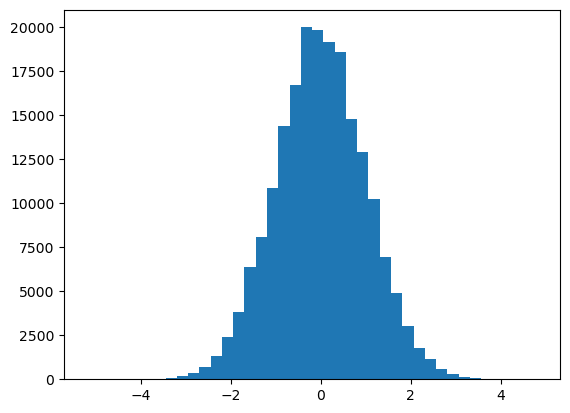

In [19]:
_ = plt.hist(samples, bins=40)